<a href="https://colab.research.google.com/github/ArashDehghanyan/ml-practicres/blob/main/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.0


##Download dataset

In [35]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


In [36]:
def normailize(image, mask):
    """Normalize dataset."""
    image = tf.cast(image, tf.float32) / 255.
    mask -= 1
    return image, mask

def load_image(datapoint):
    image = tf.image.resize(datapoint['image'], (128, 128))
    mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    image, mask = normailize(image, mask)
    return image, mask

In [37]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_images = dataset['train'].map(load_image, num_parallel_calls=AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=AUTOTUNE)

In [39]:
# AUGMENTATION CLASS
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=123):
        super().__init__()
        self.augment_images = tf.keras.layers.RandomFlip('horizontal', seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip('horizontal', seed=seed)

    def call(self, images, labels):
        images = self.augment_images(images)
        labels = self.augment_labels(labels)
        return images, labels
        

In [40]:
# Input Pipeline
train_baches = (
    train_images.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().map(Augment()).prefetch(buffer_size=AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

In [41]:
from IPython.display import clear_output

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['input_image', 'True_mask', 'Predicted_mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.title(title[i])
        plt.axis('off')
    plt.show()

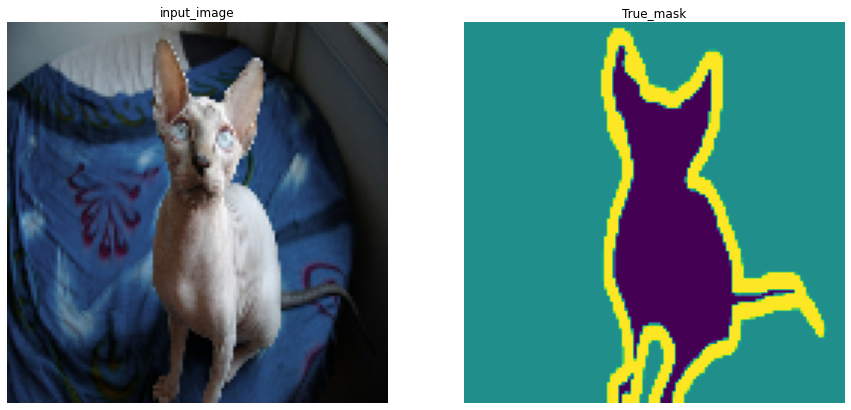

In [42]:
for images, masks in train_baches.take(1):
    sample_image, sample_mask = images[20], masks[20]
    display([sample_image, sample_mask])

##Bounding Boxes

In [43]:
def box_corner_to_center(boxes):
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    width = x2 - x1
    height = y2 - y1
    boxes = tf.stack((center_x, center_y, width, height), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    center_x, center_y, width, height = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = center_x - 0.5 * width
    x2 = center_x + 0.5 * width
    y1 = center_y - 0.5 * height
    y2 = center_y + 0.5 * height

    boxes = tf.stack((x1, y1, x2, y2), axis=-1)
    return boxes


In [44]:
boxes = tf.constant(([25., 10., 95., 95.], [10., 5, 75.5, 80.0]))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

<tf.Tensor: shape=(2, 4), dtype=bool, numpy=
array([[ True,  True,  True,  True],
       [ True,  True,  True,  True]])>

In [45]:
true_box, pred_box = box_corner_to_center(boxes)
print(true_box.numpy(), pred_box.numpy())

[60.  52.5 70.  85. ] [42.75 42.5  65.5  75.  ]


In [46]:
def boundingbox_to_rect(bbox, color):
    """It draws a bounding box around the object."""
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=3
    )


(-0.5, 127.5, 127.5, -0.5)

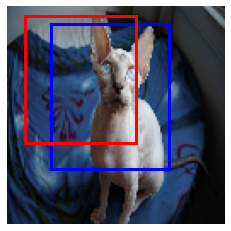

In [47]:
fig = plt.imshow(sample_image)
fig.axes.add_patch(boundingbox_to_rect(boxes[0], 'blue'))
fig.axes.add_patch(boundingbox_to_rect(boxes[1], 'red'))
fig.axes.axis('off')

In [48]:
def intersection_area(box1, box2, box_format=None):
    """Calculates the intersection area of predicted and true bounding boxes."""
    assert box_format, 'You have forgotten \'box_format\' positional argument'

    # Change to corner format if boxes are in center format
    if box_format == "center":
        box1, box2 = box_center_to_corner((box1, box2))

    box1_x1 = box1[..., 0:1]
    box1_y1 = box1[..., 1:2]
    box1_x2 = box1[..., 2:3]
    box1_y2 = box1[..., 3:4]

    box2_x1 = box2[..., 0:1]
    box2_y1 = box2[..., 1:2]
    box2_x2 = box2[..., 2:3]
    box2_y2 = box2[..., 3:4]

    # Get intersection coordinates
    x1 = tf.math.maximum(box1_x1, box2_x1)
    y1 = tf.math.maximum(box1_y1, box2_y1)
    x2 = tf.math.minimum(box1_x2, box2_x2)
    y2 = tf.math.minimum(box1_y2, box2_y2)

    intersection_area = tf.clip_by_value((x2 - x1), 0, 1e100) * tf.clip_by_value((y2 - y1), 0, 1e100)
    return intersection_area

In [49]:
intersection_area(boxes[0], boxes[1], 'corner').numpy()

array([3535.], dtype=float32)

In [50]:
def intersection_over_union(true_box, predicted_box, box_format=None):
    """Compute IoU 'Intersection over Union' metric."""
    # Check if parameter box_format is not Null
    assert box_format, "missing one positional argument: 'box_format'"
    
    # Calculate intersection area
    intersection = intersection_area(true_box, predicted_box, box_format)

    true_box_x1 = true_box[..., 0:1]
    true_box_y1 = true_box[..., 1:2]
    true_box_x2 = true_box[..., 2:3]
    true_box_y2 = true_box[..., 3:4]

    pred_box_x1 = predicted_box[..., 0:1]
    pred_box_y1 = predicted_box[..., 1:2]
    pred_box_x2 = predicted_box[..., 2:3]
    pred_box_y2 = predicted_box[..., 3:4]

    true_box_area = abs((true_box_x2 - true_box_x1) * (true_box_y2 - true_box_y1))
    pred_box_area = abs((pred_box_x2 - pred_box_x1) * (pred_box_y2 - pred_box_y1))

    return intersection / (true_box_area + pred_box_area - intersection + 1e-6)

In [51]:
intersection_over_union(boxes[1], boxes[0], 'corner')[0].numpy()

0.4824292

In [52]:
# Non max supression
def nms(bboxes, iou_threshold, threshold, box_format='corner'):

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)
        
        bboxes = [
                  box 
                  for box in bboxes 
                  if box[0] != chosen_box[0]
                  or intersection_over_union(
                      tf.constant(chosen_box[2:]),
                      tf.constant(box[2:]),
                      box_format=box_format
                  ) < iou_threshold
        ]
        bboxes_after_nms.append(chosen_box)
        
    return bboxes_after_nms

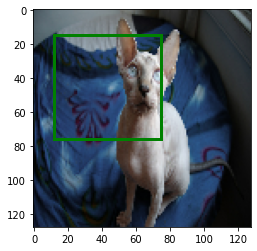

In [53]:
boxes = [[1, 0.9, 12., 14.5, 75., 76.0], [1, 0.84, 15., 17., 87., 79.]]

fig = plt.imshow(sample_image)
for box in nms(boxes, 0.5, 0.5):
    fig.axes.add_patch(
        boundingbox_to_rect(box[2:], 'green')
    )


In [1]:
from collections import Counter
import tensorflow_probability as tfp


def mean_average_precision(
    pred_boxes, true_boxes, iou_thershold=0.5, box_format='corner', num_classes=20
):
    # pred_boxes (list): [[train_idx, class_pred, prob_score, x1, y1, x2, y2], ...]
    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)
        
        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)
        # img 0 has 3 bboxes
        # img 1 has 4 bboxes
        # amount_bboxes = {0:3, 1:4}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = tf.zeros(val)
        
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = tf.zeros((len(detections)))
        FP = tf.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]
            num_ground_truth = len(ground_truth_img)
            best_iou = 0 # best iou

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    tf.constant(detection[3:]), tf.constant(gt[3:]), box_format
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx   # Best ground truth index

            if best_iou > iou_thershold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    # This bounding box was covered already
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1
        # True positive cumulative sum
        # [1, 1, 0, 1, 0] -> [1, 2, 2, 3, 3]
        TP_cumsum = tf.cumsum(TP, axis=0)
        FP_cumsum = tf.cumsum(FP, axis=0)

        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = tf.concat((tf.constant([1.]), precisions), axis=0)
        recalls = tf.concat((tf.constant([0.]), recalls), axis=0)
        average_precisions.append(tfp.math.trapz(precisions, recalls))
    
    return sum(average_precisions) / len(average_precisions)
